In [ ]:
%pip install -r requirements.txt

In [ ]:
# for using tobac conda is needed, please install it first
# for the used notebook: install conda environment from environment.yml and add it as kernel, the following has to be inserted in the terminal
conda env create -f environment.yml
conda activate tobac-conda-env
python -m ipykernel install --user --name=tobac-conda-env --display-name="Python (tobac-conda-env)"

### Tobac Notebook
Notebook for calculating the trajectories of cells. Notebook is inspired by: <br>
https://tobac-tutorials.readthedocs.io/en/latest/tutorials/Example_OLR_Tracking_satellite/Example_OLR_Tracking_satellite.html# <br>
Tutorial by tobac <br><br>
The radar data must be added in data\CZC22124 <br>
for using the notebook, please install conda and the environment like it is mentioned above

In [2]:
# import packages
import xarray
import tobac
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import pandas as pd
import pyproj
import numpy as np

In [3]:
# Disable unneeded warnings (see tobac examples on https://tobac-tutorials.readthedocs.io/en/latest/tutorials)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [ ]:
# function reads the radar max-echo data from the h5 files into a xarray
# 1) transform the x and y axes (starting at 0 in the dataset) to swiss coordinates and slice out switzerland
# 2) renames the dimension of the xarray to be tobac compatible
# 3) deletes non values with nan values (non values being -31.5 per definition of the CZC data)
def collect_datasets_from_folder(folder_path):
    
    # read in h5 files
    all_files = os.listdir(folder_path)
    h5_files = [f for f in all_files if f.endswith('.h5')]

    # prepare loop  
    # prepare slice out switzerland
    min_y = 172
    max_y = 415
    min_x = 212
    max_x = 603
    
    x_min = 2255024.26560000004246831
    y_max = 1480242.1095000000204891
    
    cell_size = 1000
    datasets = []

    # slice out, transform and add to xarray
    for h5_file in h5_files:
        file_path = os.path.join(folder_path, h5_file)
        with xarray.open_dataset(file_path, group='/dataset1/data1')['data'] as ds:
            
            ds = ds.rename({'phony_dim_1': 'x','phony_dim_0': 'y'})
            
            # transform LV95
            ds = ds.assign_coords(x=ds.x*cell_size + x_min)
            ds = ds.assign_coords(y= y_max - ds.y*cell_size)
            
            # slice and only take non values
            ds = ds.isel(y=slice(min_y, max_y), x=slice(min_x, max_x))
            ds = ds.where(ds != -31.5)
            datasets.append(ds.copy())

    return datasets

radar_folder_path = "data/CZC22124"
datasets_list = collect_datasets_from_folder(radar_folder_path)

In [5]:
# create and add time vector to xarray
datetime = pd.date_range("2022-05-04", periods=288, freq="5min")
data = xarray.concat(datasets_list, pd.Index(datetime, name='time'))

In [6]:
# validate data
display(data)

<xarray.DataArray 'data' (time: 288, y: 243, x: 391)>
array([[[-28.5, -28.5, -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        ...,
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        [-30.5, -30.5, -30.5, ..., -29.5, -28. , -28. ]],

       [[-28.5, -28.5, -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        ...,
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        [-30.5, -30.5, -30.5, ..., -29.5, -28. , -28. ]],

       [[-28.5, -28.5, -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        ...,
...
        ...,
        [ 23.5,  23.5,  23. , ..., -28. , -28. , -28. ],
        [ 24. ,  25.5,  23.5, ..., -28. , -28. , -28. ],
        [ 26. ,  27.5,  22.5, ..., -29.5, -28. , -28. ]],

       [[-28.5, -28.5, -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        ...,
        [ 29. ,  27.5,  25.5, ..., -28. , -28. , -28. ],
        [ 29.5,  28. ,  27.5, ..., -28. , -28. , -28. ],
        [ 29.5,  29. ,  26.5, ..., -29.5, -28. , -28. ]],

       [[-28.5, -28.5, -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28.5, ..., -28. , -28. , -28. ],
        [-28. , -28. , -28. , ..., -28. , -28. , -28. ],
        ...,
        [ 29. ,  30. ,  30.5, ..., -28. , -28. , -28. ],
        [ 29. ,  29.5,  30. , ..., -28. , -28. , -28. ],
        [ 28. ,  27.5,  29. , ..., -29.5, -28. , -28. ]]])
Coordinates:
  * x        (x) float64 2.467e+06 2.468e+06 2.469e+06 ... 2.856e+06 2.857e+06
  * y        (y) float64 1.308e+06 1.307e+06 1.306e+06 ... 1.067e+06 1.066e+06
  * time     (time) datetime64[ns] 2022-05-04 ... 2022-05-04T23:55:00
Attributes:
    IMAGE_VERSION:  1.2

In [7]:
# convert xarray to iris cube
data_ir = data.to_iris()
display(data_ir)

<iris 'Cube' of data / (unknown) (time: 288; y: 243; x: 391)>

**Feature identification:**  
identify features based on CZC max echo and a set of threshold values

In [10]:
# Set up directory to save data and plots
savedir = Path("Save/CZC-20220504/20240223_final")
if not savedir.is_dir():
    savedir.mkdir()

plot_dir = Path("Plot/CZC-20220504/20240223_final")
if not plot_dir.is_dir():
    plot_dir.mkdir()

In [11]:
# Determine temporal and spatial sampling of the input data
dxy, dt = tobac.get_spacings(data_ir, grid_spacing=-1000)
print(dxy)

-1000


In [12]:
# parameters for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=1
parameters_features['n_min_threshold']=1
parameters_features['target']='maximum'
parameters_features['threshold']=[15, 35, 50, 55]

In [13]:
# Feature detection and save results to file
print('starting feature detection')
Features = tobac.feature_detection_multithreshold(data_ir,dxy,**parameters_features)
print(Features)
Features.to_hdf(savedir / 'Features.h5','table')
print('feature detection performed and saved')

starting feature detection
       frame  idx      hdim_1      hdim_2  num  threshold_value  feature  \
0          0    1   22.935502  289.514446   33               15        1   
1          0    2   46.739134  390.000000    4               15        2   
2          0    3   70.777109  356.777109    2               15        3   
3          0    4  106.729136  217.000000    2               15        4   
4          0    5  120.279860  307.903521    4               15        5   
...      ...  ...         ...         ...  ...              ...      ...   
19001    287   56  196.147696  227.461349   16               35    19002   
19002    287   57  203.444195  253.746263   39               35    19003   
19003    287   58  201.600806  221.907155    6               35    19004   
19004    287   59  212.000000  193.698685    2               35    19005   
19005    287   60  241.723775    9.551384    4               35    19006   

                      time              timestr             

**Segmentation:**  
segmentation is performed based on the CZC max echo and a threshold value to determine the cloud areas.

In [15]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=15

In [16]:
# Perform segmentation and save results to files:
Mask_CZC, Features_CZC = tobac.segmentation_2D(Features,data_ir,dxy,**parameters_segmentation)
print('segmentation data_ir performed, start saving results to files')
iris.save([Mask_CZC], savedir / 'Mask_Segmentation_data_ir.nc', zlib=True, complevel=4)                
Features_CZC.to_hdf(savedir / 'Features_data_ir.h5', 'table')
print('segmentation CVC performed and saved')

segmentation data_ir performed, start saving results to files
segmentation CVC performed and saved


**Trajectory linking:**  
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects

In [17]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=25
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [18]:
# Perform linking and save results to file:
Track = tobac.linking_trackpy(Features,data_ir,dt=dt,dxy=dxy,**parameters_linking)

Frame 287: 51 trajectories present.


In [19]:
Track.to_hdf(savedir / 'Track.h5','table')

In [20]:
# save to pandas table
trajectories = pd.read_hdf(savedir / 'Track.h5', key='table') # Track.h5
trajectories.to_csv('trajectories.csv', index=False)

In [21]:
# validate tracks
display(Track)

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,y,x,cell,time_cell
0,0,1,22.935502,289.514446,33,15,1,2022-05-04 00:00:00,2022-05-04 00:00:00,1.285307e+06,2.756539e+06,1,0 days 00:00:00
1,0,2,46.739134,390.000000,4,15,2,2022-05-04 00:00:00,2022-05-04 00:00:00,1.261503e+06,2.857024e+06,2,0 days 00:00:00
2,0,3,70.777109,356.777109,2,15,3,2022-05-04 00:00:00,2022-05-04 00:00:00,1.237465e+06,2.823801e+06,3,0 days 00:00:00
3,0,4,106.729136,217.000000,2,15,4,2022-05-04 00:00:00,2022-05-04 00:00:00,1.201513e+06,2.684024e+06,4,0 days 00:00:00
4,0,5,120.279860,307.903521,4,15,5,2022-05-04 00:00:00,2022-05-04 00:00:00,1.187962e+06,2.774928e+06,5,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19001,287,56,196.147696,227.461349,16,35,19002,2022-05-04 23:55:00,2022-05-04 23:55:00,1.112094e+06,2.694486e+06,4095,0 days 00:25:00
19002,287,57,203.444195,253.746263,39,35,19003,2022-05-04 23:55:00,2022-05-04 23:55:00,1.104798e+06,2.720771e+06,4020,0 days 01:05:00
19003,287,58,201.600806,221.907155,6,35,19004,2022-05-04 23:55:00,2022-05-04 23:55:00,1.106641e+06,2.688931e+06,4119,0 days 00:10:00
19004,287,59,212.000000,193.698685,2,35,19005,2022-05-04 23:55:00,2022-05-04 23:55:00,1.096242e+06,2.660723e+06,3670,0 days 04:20:00


**Visualisation:**  

In [62]:
# Set extent of maps created in the following cells:
# axis_extend=[1238242.1095 ,1480242.1095, 2255024.2656, 2645024.2656] # swiss coordinates
axis_extend=[5.1, 11, 45.82,47.81]

In [63]:
# apply LV95 to wgs84 transformation
transformer = pyproj.Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

Track['longitude'], Track['latitude'] = (Track['x'].to_numpy(), Track['y'].to_numpy())

display(Track)

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,y,x,cell,time_cell,longitude,latitude
0,0,1,22.935502,289.514446,33,15,1,2022-05-04 00:00:00,2022-05-04 00:00:00,1.285307e+06,2.756539e+06,1,0 days 00:00:00,2.756539e+06,1.285307e+06
1,0,2,46.739134,390.000000,4,15,2,2022-05-04 00:00:00,2022-05-04 00:00:00,1.261503e+06,2.857024e+06,2,0 days 00:00:00,2.857024e+06,1.261503e+06
2,0,3,70.777109,356.777109,2,15,3,2022-05-04 00:00:00,2022-05-04 00:00:00,1.237465e+06,2.823801e+06,3,0 days 00:00:00,2.823801e+06,1.237465e+06
3,0,4,106.729136,217.000000,2,15,4,2022-05-04 00:00:00,2022-05-04 00:00:00,1.201513e+06,2.684024e+06,4,0 days 00:00:00,2.684024e+06,1.201513e+06
4,0,5,120.279860,307.903521,4,15,5,2022-05-04 00:00:00,2022-05-04 00:00:00,1.187962e+06,2.774928e+06,5,0 days 00:00:00,2.774928e+06,1.187962e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19001,287,56,196.147696,227.461349,16,35,19002,2022-05-04 23:55:00,2022-05-04 23:55:00,1.112094e+06,2.694486e+06,4095,0 days 00:25:00,2.694486e+06,1.112094e+06
19002,287,57,203.444195,253.746263,39,35,19003,2022-05-04 23:55:00,2022-05-04 23:55:00,1.104798e+06,2.720771e+06,4020,0 days 01:05:00,2.720771e+06,1.104798e+06
19003,287,58,201.600806,221.907155,6,35,19004,2022-05-04 23:55:00,2022-05-04 23:55:00,1.106641e+06,2.688931e+06,4119,0 days 00:10:00,2.688931e+06,1.106641e+06
19004,287,59,212.000000,193.698685,2,35,19005,2022-05-04 23:55:00,2022-05-04 23:55:00,1.096242e+06,2.660723e+06,3670,0 days 04:20:00,2.660723e+06,1.096242e+06


< GeoAxes: PROJCRS["CH1903+ / LV95",BASEGEOGCRS["CH1903+",DATUM["CH1903+",ELLIPSOID["Bessel 1841",6377397.155,299.1528128,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4150]],CONVERSION["Swiss Oblique Mercator 1995",METHOD["Hotine Oblique Mercator (variant B)",ID["EPSG",9815]],PARAMETER["Latitude of projection centre",46.9524055555556,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8811]],PARAMETER["Longitude of projection centre",7.43958333333333,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8812]],PARAMETER["Azimuth of initial line",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8813]],PARAMETER["Angle from Rectified to Skew Grid",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8814]],PARAMETER["Scale factor on initial line",1,SCALEUNIT["unity",1],ID["EPSG",8815]],PARAMETER["Easting at projection centre",2600000,LENGTHUNIT["metre",1],ID["EPSG",8816]],PARAMETER["Northing at projection centre",1200000,LENGTHUNIT["metre",1],I

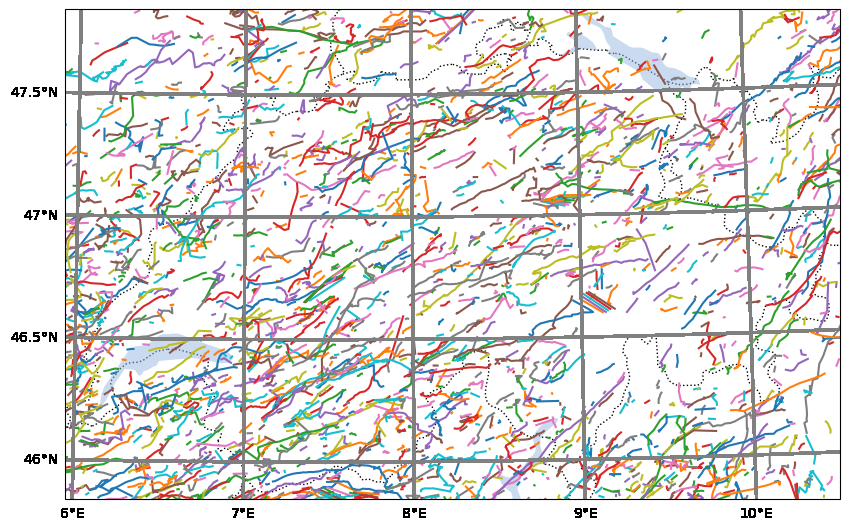

In [64]:
# Plot map with all individual tracks
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.epsg(2056)})

ax_map.add_feature(cfeature.BORDERS, linestyle=':')
ax_map.add_feature(cfeature.LAKES, alpha=0.5)  
ax_map=tobac.map_tracks(Track,axis_extent=axis_extend,axes=ax_map)

In [65]:
# save file
savefile_plot = plot_dir / 'tracks_bzb.png'
fig_map.savefig(savefile_plot)

In [66]:
# Create animation of tracked clouds and outlines with CZC as a background field
animation_test_tobac=tobac.animation_mask_field(Track,Features,data_ir,Mask_CZC,
                                          axis_extent=axis_extend, #figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=10,cmap='Blues_r', label_colorbar='QPE product, best estimation of precipitation intensity at ground (mm/h)',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [ ]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

In [ ]:
# Save animation to file:
savefile_animation=plot_dir / 'Animation.mp4'
animation_test_tobac.save(savefile_animation,dpi=200)
print(f'animation saved to {savefile_animation}')